In [1]:
import brian2 as b2
from brian2 import *
from keras.datasets import mnist
from tqdm import tqdm
from sklearn import metrics
import numpy as np
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from spikingjelly import visualizing
import utils

100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
WARNING    C:\Users\bgre4\AppData\Local\JetBrains\PyCharm2023.2\demo\PyCharmLearningProject\venv\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
 [py.warnings]


C какими классами нейроны спайкуют чаще всего:
 {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: 1, 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: 1, 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: 1, 42: 1, 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: 1, 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 86: [], 87: [], 88: [], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [], 97: [], 98: [], 99: []}
1.0
[[1]]
[[-80.         -79.98       -79.96002    ... -63.63540481 -63.63176946
  -63.62813775]
 [-80.         -79.98       -79.96002    ... -62.36055725 -62.3581967

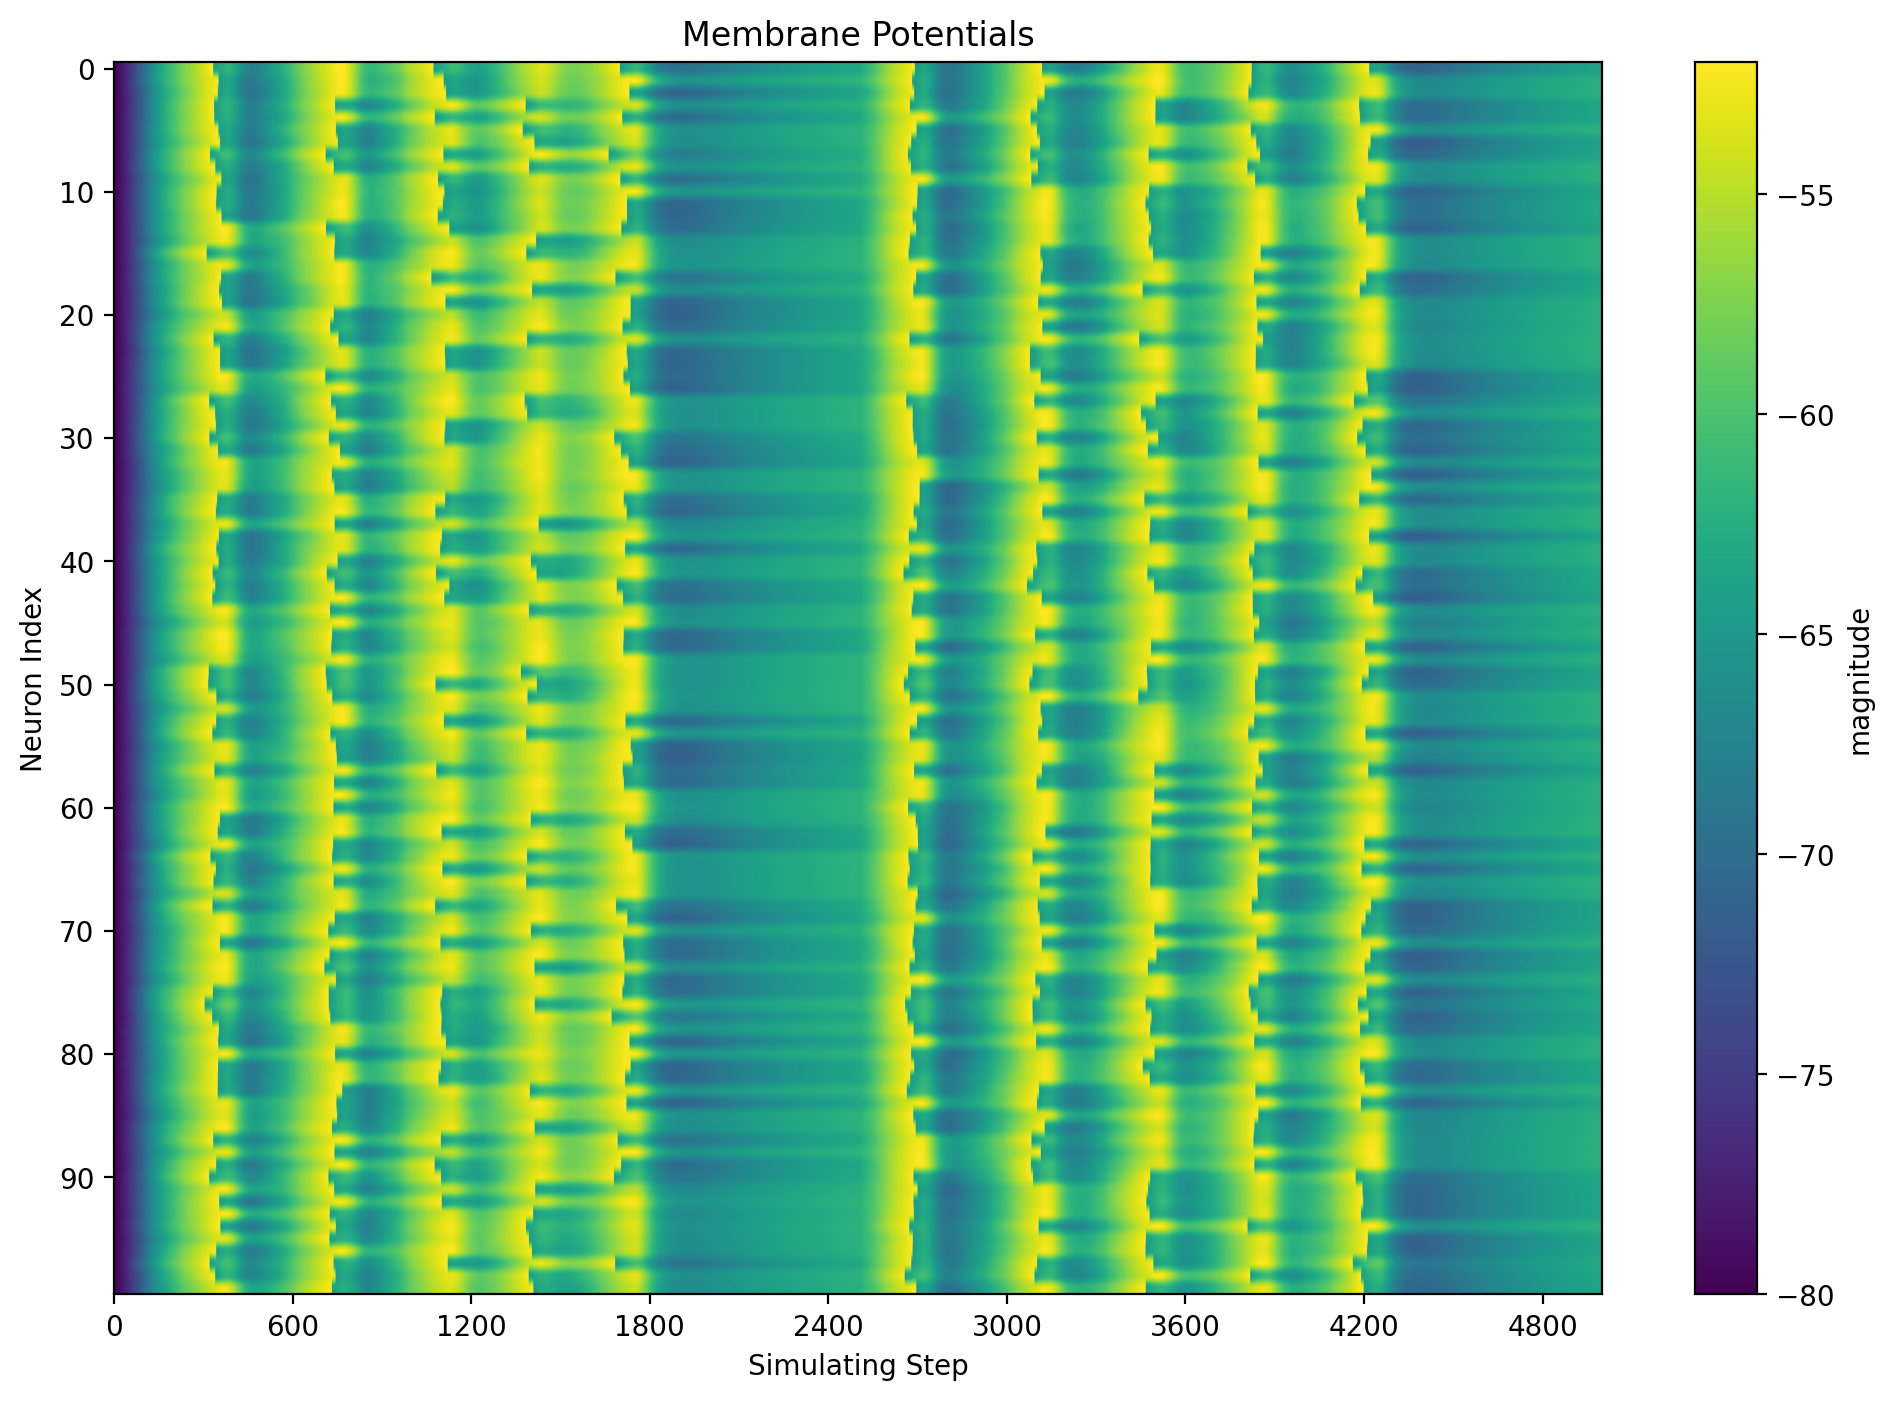

In [4]:
n_input = 28 * 28  # input layer
n_e = 100  # e - excitatory
n_i = n_e  # i - inhibitory

v_rest_e = -60. * mV  # v - membrane potential
v_reset_e = -65. * mV
v_thresh_e = -52. * mV

v_rest_i = -60. * mV
v_reset_i = -45. * mV
v_thresh_i = -40. * mV

taupre = 20 * ms # tau пресинаптического
taupost = taupre 
gmax = .05  # .01 макс разница весов (регуляризация)
dApre = .01 # максимальное возможное изменение весов пресинаптического
dApost = -dApre * taupre / taupost * 1.05 
dApost *= gmax
dApre *= gmax

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp = '''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre = '''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)''' # посмотреть что делает clip
post = '''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''


class Model:
    def __init__(self, debug=False): #флаг для проверки
        app = {}

        # Входные изображения кодируются как скорость Пуассоновских генераторов
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input) * Hz, name='PG')

        # Группа возбуждающих нейронов
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1 
            ''' # LIF, 3 строка для обратной связи
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5 * ms, reset='v=v_reset_e',
                                method='euler', name='EG')
        app['EG'].v = v_rest_e - 20. * mV # инициализация напряжения (меньше сброса)

        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM') # firing rate

        # Группа ингибирующих нейронов
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2 * ms, reset='v=v_reset_i',
                                method='euler', name='IG')
        app['IG'].v = v_rest_i - 20. * mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        # poisson generators one-to-all excitatory neurons with plastic connections
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax'  # random weights initialisation
        app['S1'].lr = 1  # enable stdp

        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380, :4], name='S1M')

            # excitation neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], stdp, on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms' # задержка между возбужд и ингиб
        app['S2'].w = 3  # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], stdp, on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03  # weights are selected in such a way as to maintain a balance between excitation and ibhibition
        
        # сделать по аналогии с апп S1

        self.net = Network(app.values()) # получение значений словаря
        self.net.run(0 * second) # инициализация сети

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, epoch=1):
        
        self.net['S1'].lr = 1
        self.net['S2'].lr = 1
        self.net['S3'].lr = 1 # stdp on 

        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel() * Hz # кодирование мниста в спайки
                self.net.run(0.35 * second) # прогон по сети 

                # passive mode - когда входные спайки кончились, нет внешнего стимула
                self.net['PG'].rates = np.zeros(n_input) * Hz 
                self.net.run(0.15 * second)

    def evaluate(self, X):
        
        self.net['S1'].lr = 0
        self.net['S2'].lr = 0
        self.net['S3'].lr = 0 # stdp off

        features, classification = [], []
        for idx in tqdm(range(len(X))):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)

            # active mode
            self.net['PG'].rates = X[idx].ravel() * Hz
            self.net.run(0.35 * second)

            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))

            # passive mode
            self.net['PG'].rates = np.zeros(n_input) * Hz
            self.net.run(0.15 * second)

            self.net.remove(self.net['RM'])# удалить rate монитор

        return features
    
    def classification(self, X, label, n_e, num_neurons = 5):
        
        '''По сути запись какие нейроны спайкуют
        при каком классе
        должна быть на этапе обучения, 
        после мы берем функции снизу и формируем список,
        какие нейроны спайкуют чаще всего при определенном классе.
        Получившийся словарь - ключ это индекс нейрона, 
        а значение - класс в котором он чаще всего спайкует
        
        n_e - число нейронов в выходном слое
        num_neurons - кол-во нейронов, которые мы хотим отнести 
        к определенному классу (Default - 5)'''
        
        self.net['S1'].lr = 0
        self.net['S2'].lr = 0
        self.net['S3'].lr = 0 # stdp off
        
        neurons_with_classes = {i: [] for i in range(n_e)}
        
        for idx in tqdm(range(len(X))):
            spikes = SpikeMonitor(self.net['IG'], name='Output')
            self.net.add(spikes)

            # active mode
            self.net['PG'].rates = X[idx].ravel() * Hz
            self.net.run(0.35 * second)

            # passive mode
            self.net['PG'].rates = np.zeros(n_input) * Hz
            self.net.run(0.15 * second)
            
            indexes = np.argsort(spikes.count)[-num_neurons:]
            
            self.net.remove(self.net['Output'])# удалить rate монитор
            
            for item in indexes:
                neurons_with_classes[item].append(label[idx])
        
        for key in neurons_with_classes.keys():
            
            if len(neurons_with_classes[key]) != 0:
                neurons_with_classes[key] = max(neurons_with_classes[key], 
                                                key=neurons_with_classes[key].count)
            else:
                continue
                
        return neurons_with_classes
        
        
def plot_w(S1M):
    
    '''монитор состояния весов перых четырех синапсов во входном слое'''
    
    plt.rcParams["figure.figsize"] = (20, 10)
    subplot(311)
    plot(S1M.t / ms, S1M.w.T / gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t / ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t / ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();


def plot_v(ESM, ISM, neuron=13):
    
    '''напряжение на двух нейронах в возбуждающем 
    и ингибируеющем слоях'''
    
    plt.rcParams["figure.figsize"] = (20, 6)
    cnt = -50000  # tail
    plot(ESM.t[cnt:] / ms, ESM.v[neuron][cnt:] / mV, label='exc', color='r')
    plot(ISM.t[cnt:] / ms, ISM.v[neuron][cnt:] / mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e / mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i / mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();


def plot_rates(ERM, IRM):
    
    '''частота спайкования двух нейронах в возбуждающем 
    и ингибируеющем слоях'''
    
    plt.rcParams["figure.figsize"] = (20, 6)
    plot(ERM.t / ms, ERM.smooth_rate(window='flat', width=0.1 * ms) * Hz, color='r')
    plot(IRM.t / ms, IRM.smooth_rate(window='flat', width=0.1 * ms) * Hz, color='b')
    ylabel('Rate')
    show();


def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20, 6)
    plot(ESP.t / ms, ESP.i, '.r')
    plot(ISP.t / ms, ISP.i, '.b')
    ylabel('Neuron index')
    show();


def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)

    model = Model(debug=True)
    print(X_train[:train_items])
    model.train(X_train[:train_items], epoch=1)

    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])


def main():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # simplified classification (0 1 and 8)
    # X_train = X_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
    # y_train = y_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
    # X_test = X_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]
    # y_test = y_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]

    # pixel intensity to Hz (255 becoms ~63Hz)
    X_train = X_train / 4
    X_test = X_test / 4

    X_test = X_test[:1]
    y_test = y_test[:1]

    model = Model(True)
    assign_items = len(X_test)  # 60k

    seed(0)

    classific = model.classification(X_test, [1], 100)
    f_test= model.evaluate(X_test)
    
    print('C какими классами нейроны спайкуют чаще всего:\n',
          classific)

    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_test, y_test)

    print(clf.score(f_test, y_test))

    y_pred = clf.predict(f_test)
    conf_m = confusion_matrix(y_pred, y_test)
    print(conf_m)

    model.net.store('train', 'train.b2')

    # --- Датасет с данными о модели ---
    # time - время
    # exc_rate, inh_rate - частота спайкования возбуждающих и ингибирующих нейронов
    
    # 
    data_dict = {'time': model['ERM'].t / b2.ms,
                 'exc_rate': model['ERM'].smooth_rate(window='flat', width=0.1 * b2.ms) / b2.Hz,
                 'inh_rate': model['IRM'].smooth_rate(window='flat', width=0.1 * b2.ms) / b2.Hz} 


    # (n_exc = n_inh)
    # n_exc_{i}, n_inh_{i} - мембранный потенциал возбуждающих и ингибирующих нейронов

    for i in range(n_e):
        data_dict[f'n_exc_{i}'] = model['ESM'].v[i] / mV
        data_dict[f'n_inh_{i}'] = model['ISM'].v[i] / mV

    labels = []
    for label in y_test:
        labels.append([label] * 5000)
    data_dict['labels'] = list(itertools.chain(*labels))

    #dataframe = pd.DataFrame(data=data_dict)
    #dataframe.to_csv('data.csv', index=False)

    print(model['ESM'].v / b2.mV)

    visualizing.plot_2d_heatmap(array=np.asarray(model['ESM'].v / b2.mV).T, title='Membrane Potentials', xlabel='Simulating Step',
                                ylabel='Neuron Index', int_x_ticks=True, x_max=5000, dpi=200)

    # visualizing.plot_2d_bar_in_3d(np.asarray(model['ESM'].v[0:6] / b2.mV).T, title='voltage of neurons', xlabel='neuron index',
    #                               ylabel='simulating step', zlabel='voltage', int_x_ticks=True, int_y_ticks=True,
    #                               int_z_ticks=True, dpi=200)

    plt.show()

    # utils.plot_rates(model['ERM'], model['IRM'])

    # model.net.restore()


if __name__ == '__main__':
    main()


# попробовать добавить малый мир (network x),
# сделать разметку для нейронов после обучения
# перенести ижекевича (2003)